In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [7]:

path = "/home/seobin1027/tasks/new_log_data/data/results/AHR2_merged.csv"
df = pd.read_csv(path)
df = df.drop(columns=["timestamp", "TimeUS"], axis=1)

X = df.drop(columns=['label'])
y = df['label']


X_trn, X_val_tst, y_trn, y_val_tst = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_tst, y_val, y_tst = train_test_split(X_val_tst, y_val_tst, test_size=0.5, random_state=42)

scaler = StandardScaler()
scaled_x_trn = scaler.fit_transform(X_trn)
scaled_x_val = scaler.transform(X_val)



In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import os

# 저장 경로 설정
save_dir = "./tabnet_logs"
os.makedirs(save_dir, exist_ok=True)

# 모델 생성
tabnet_model = TabNetClassifier(
    n_d=64, n_a=64, n_steps=5,
    gamma=1.5, n_independent=2, n_shared=2,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax',  
    verbose=1,
    seed=42,
    device_name='cuda' if torch.cuda.is_available() else 'cpu'
)

# 학습
tabnet_model.fit(
    X_train=scaled_x_trn, y_train=y_trn,
    eval_set=[(scaled_x_val, y_val)],
    eval_name=["valid"],
    eval_metric=["accuracy", "logloss"],
    max_epochs=200,
    patience=20,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
)
# 모델 저장
tabnet_model.save_model(os.path.join(save_dir, "tabnet_best_model"))

# 학습 기록 저장
history = tabnet_model.history


/home/seobin1027/miniconda3/envs/drone/lib/python3.11/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.04201 | valid_accuracy: 0.99877 | valid_logloss: 0.00388 |  0:00:04s
epoch 1  | loss: 0.00902 | valid_accuracy: 0.99448 | valid_logloss: 0.01017 |  0:00:08s
epoch 2  | loss: 0.00251 | valid_accuracy: 0.99968 | valid_logloss: 0.00056 |  0:00:12s
epoch 3  | loss: 0.00091 | valid_accuracy: 0.99917 | valid_logloss: 0.00209 |  0:00:16s
epoch 4  | loss: 0.00166 | valid_accuracy: 0.99996 | valid_logloss: 0.0001  |  0:00:21s
epoch 5  | loss: 0.00055 | valid_accuracy: 1.0     | valid_logloss: 8e-05   |  0:00:25s
epoch 6  | loss: 0.00401 | valid_accuracy: 0.99964 | valid_logloss: 0.00196 |  0:00:29s
epoch 7  | loss: 0.00425 | valid_accuracy: 0.99873 | valid_logloss: 0.00432 |  0:00:35s
epoch 8  | loss: 0.00103 | valid_accuracy: 0.99984 | valid_logloss: 0.00034 |  0:00:40s
epoch 9  | loss: 0.0006  | valid_accuracy: 0.99992 | valid_logloss: 0.00016 |  0:00:44s
epoch 10 | loss: 0.00053 | valid_accuracy: 0.99996 | valid_logloss: 0.00011 |  0:00:48s
epoch 11 | loss: 0.00044 | valid

/home/seobin1027/miniconda3/envs/drone/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at ./tabnet_logs/tabnet_best_model.zip


KeyError: 'valid_loss'

Loss 기록 저장 완료 -> ./tabnet_logs/loss_history.csv
Best 모델 복구 완료
Best Validation Loss at Epoch 78


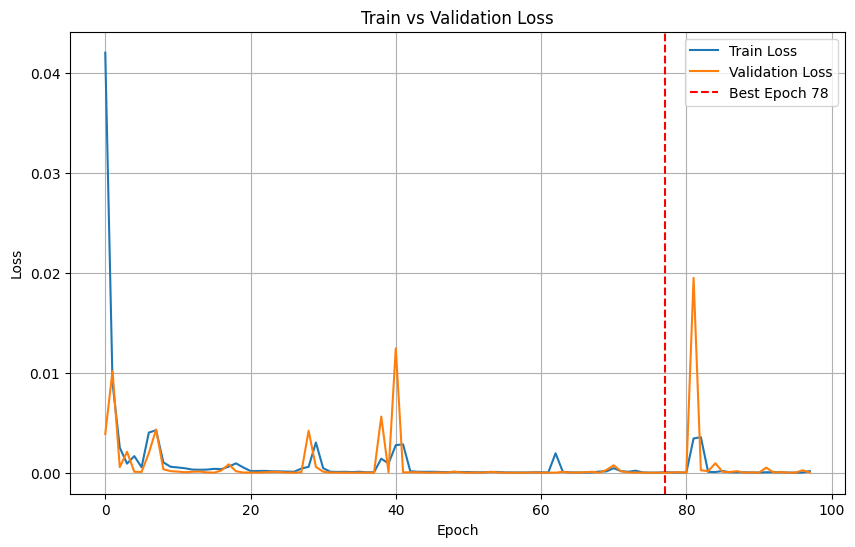


Test Set Metrics
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1 Score : 1.0000
ROC AUC  : 1.0000

Confusion Matrix (Test):
[[12439     0]
 [    0 12756]]

Classification Report (Test):
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000     12439
           1     1.0000    1.0000    1.0000     12756

    accuracy                         1.0000     25195
   macro avg     1.0000    1.0000    1.0000     25195
weighted avg     1.0000    1.0000    1.0000     25195



In [23]:

loss_df = pd.DataFrame({
    'train_loss': history['loss'],
    'valid_loss': history['valid_logloss']
})
loss_df.to_csv(os.path.join(save_dir, "loss_history.csv"), index=False)
print(f"Loss 기록 저장 완료 -> {save_dir}/loss_history.csv")

# Best 모델 복구
tabnet_model.load_model(os.path.join(save_dir, "tabnet_best_model.zip"))
print("Best 모델 복구 완료")

# Best Epoch 계산
best_epoch = np.argmin(history['valid_logloss']) + 1
print(f"Best Validation Loss at Epoch {best_epoch}")

# 그래프
plt.figure(figsize=(10, 6))
plt.plot(loss_df['train_loss'], label="Train Loss")
plt.plot(loss_df['valid_loss'], label="Validation Loss")
plt.axvline(x=best_epoch-1, color='red', linestyle='--', label=f'Best Epoch {best_epoch}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid()
plt.savefig(os.path.join(save_dir, "loss_curve.png"))
plt.show()

# Test 데이터로 최종 성능 평가
scaled_x_tst = scaler.transform(X_tst)  # 반드시 스케일
test_preds = tabnet_model.predict(scaled_x_tst)
test_probs = tabnet_model.predict_proba(scaled_x_tst)[:, 1]

print("\nTest Set Metrics")
print(f"Accuracy : {accuracy_score(y_tst, test_preds):.4f}")
print(f"Precision: {precision_score(y_tst, test_preds):.4f}")
print(f"Recall   : {recall_score(y_tst, test_preds):.4f}")
print(f"F1 Score : {f1_score(y_tst, test_preds):.4f}")
print(f"ROC AUC  : {roc_auc_score(y_tst, test_probs):.4f}")
print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_tst, test_preds))
print("\nClassification Report (Test):")
print(classification_report(y_tst, test_preds, digits=4))


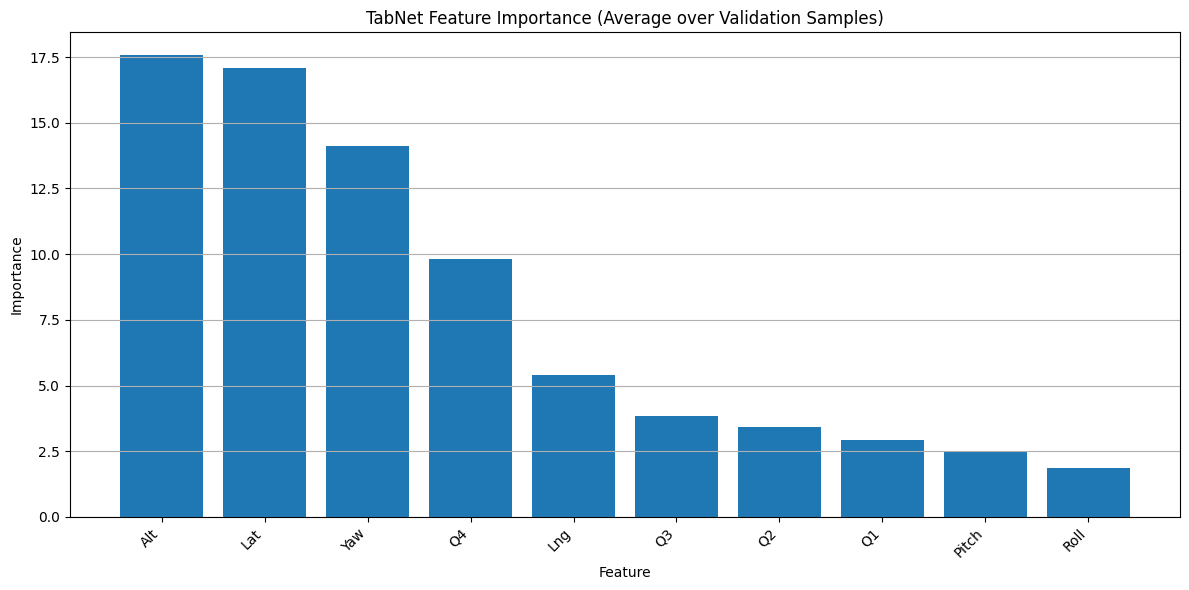

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# 1. 평균 feature importance 계산
mean_feature_importance = np.mean(explain_matrix, axis=0)

# 2. feature 이름이 있으면 사용, 없으면 index
feature_names = list(X.columns)

# 3. 정렬 (내림차순으로 보기 좋게)
sorted_idx = np.argsort(mean_feature_importance)[::-1]
sorted_importance = mean_feature_importance[sorted_idx]
sorted_features = [feature_names[i] for i in sorted_idx]

# 4. 시각화
plt.figure(figsize=(12, 6))
plt.bar(range(len(sorted_importance)), sorted_importance)
plt.xticks(range(len(sorted_features)), sorted_features, rotation=45, ha='right')
plt.title("TabNet Feature Importance (Average over Validation Samples)")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.grid(axis='y')
plt.show()


In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

# TabNet 모델 생성
tabnet_model = TabNetClassifier(
    n_d=64, n_a=64, n_steps=5,
    gamma=1.5, n_independent=2, n_shared=2,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax'  # 'sparsemax'도 가능
)

# 학습
tabnet_model.fit(
    X_train=scaled_x_trn, y_train=y_trn,
    eval_set=[(scaled_x_val, y_val)],
    eval_name=["valid"],
    eval_metric=["accuracy"],
    max_epochs=200,
    patience=20,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

# 예측
preds = tabnet_model.predict(X_val)
